## 0. Goal
A workflow to apply trained VAE network, UMAP embedding, and HDBSCAN to new (untrained) data. Obtain embedding and cluster labels. <br>
This notebook is for warble calls. <br>
Input a dbase with WhisperSeg coarse segmentations, output for each 'v' syllable a specific cluster id, e.g. 'v1', 'v2', etc

In [1]:
import os, sys, shutil, glob, scipy, pickle, tqdm, math, seaborn, netCDF4
from collections import OrderedDict
from scipy.io import wavfile, loadmat, savemat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
from joblib import Parallel, delayed
import h5py
from scipy import interpolate
import importlib
import torch
import random
import itertools
from collections import Counter
from matplotlib.patches import Patch
from torch.utils.data import Dataset, DataLoader
import distinctipy
import hdbscan

In [2]:
# import the VAE scripts, need to change if saved in a different folder
VAE_script_path = '/home/zz367/ProjectsU/WarbleAnalysis/Jupyter/ZZ_VAE_UMAP/'
sys.path.insert(1, VAE_script_path)
# load Han's script on VAE architecture
import Han_VAE_scriptNoPitch
importlib.reload(Han_VAE_scriptNoPitch)
import ZZ_VAE_scriptNoPitch
importlib.reload(ZZ_VAE_scriptNoPitch)

<module 'ZZ_VAE_scriptNoPitch' from '/home/zz367/ProjectsU/WarbleAnalysis/Jupyter/ZZ_VAE_UMAP/ZZ_VAE_scriptNoPitch.py'>

In [3]:
# import WhipserSeg model and utils 
fd_wseg = '/home/zz367/LabSoftware/WhisperSeg/'
os.chdir(fd_wseg)
from model import WhisperSegmenterFast, WhisperSegmenter
from copy import deepcopy
from train import evaluate
from datautils import get_audio_and_label_paths
from audio_utils import SpecViewer

In [4]:
# import my WhisperSeg utility script
Wh_script_path = '/home/zz367/ProjectsU/WarbleAnalysis/Jupyter/WhisperSeg/'
sys.path.insert(1, Wh_script_path)
import ZZ_WhisperSeg_script
importlib.reload(ZZ_WhisperSeg_script)

<module 'ZZ_WhisperSeg_script' from '/home/zz367/ProjectsU/WarbleAnalysis/Jupyter/WhisperSeg/ZZ_WhisperSeg_script.py'>

In [5]:
num_cpu = 48   # number of cpu threads to use for parallel processing, primarily for wav preprocessing
dev_id = 'cuda:0'  # what gpu device to use

## 1. Dataset-specific inputs

In [9]:
# what syllable to focus on 
focal_syl = 'v' # warble calls
# Specify where data are, including fd_data_base and what conditions to run VAE with 
fd_z4 = '/mnt/z4/'
pairID = 'pair5CU29CU55'
birdIDs = ['pair5RigCCU29', 'pair5Rig0CU25']  # two birds in the dyadic setup
focal_bird = 'pair5RigCCU29'
# what dates to analyze
data_date = '2024-09-12'
# specify what VAE network to use, this folder should contain the VAE network weights, UMAP and HDBSCAN pickled models
runName = f'{pairID}_20241121_v7_discreteCallShortWin'
fd_model_base = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'Figures', pairID, 'VAE', 'Results', runName)
# what base folder is unseen data located, pointed to the dbase location, the dbase should have been annotated with whisperSeg
fd_data_base = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'DbaseFiles', pairID)
# what type of dbase to analyze, will be used as wildcard to grab dbase files
dbase_type = 'good.Wsp.dbase'
print('Load VAE/UMAP/HDBSCAN model from: ', fd_model_base)
# where to save the intermediate results
fd_save_base = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'Figures', pairID, 'VAE', 'ApplyRes')
if not os.path.exists(fd_save_base):
    os.makedirs(fd_save_base)
print('Save intermediate results to: ', fd_save_base)

Load VAE/UMAP/HDBSCAN model from:  /mnt/z4/zz367/EphysMONAO/Analyzed/Figures/pair5CU29CU55/VAE/Results/pair5CU29CU55_20241121_v7_discreteCallShortWin
Save intermediate results to:  /mnt/z4/zz367/EphysMONAO/Analyzed/Figures/pair5CU29CU55/VAE/ApplyRes


## 2. Grab audio from dbase then calculate spectrogram
Need to use the same parameter values as when the network was trained

In [10]:
# nperseg and noverlap determine the resolution of spectrograms
# target_freqs define what frequency range we care about
param_chop = {'nperseg':128, 'noverlap':78, 'focal_ch': 0, 
             'target_freqs':np.linspace(100, 8000, 128), 'target_time_dim':None, 'bool_clip':True, 'clim':(-13,-5)}
# window and hop size in unit of secs
fs = 20000
frame_dur = 1/fs * (param_chop['nperseg']-param_chop['noverlap'])
print(f'each spectrogram frame in sec: {frame_dur}')

each spectrogram frame in sec: 0.0025


In [17]:
# loop through each date, grab the dbase file
fn_dbase = sorted(glob.glob(os.path.join(fd_data_base, data_date, focal_bird, 'warble', f'*{dbase_type}.mat')))[0]
# then grab the focal syllable, extract the audio, create the spectrogram
fd_save_this = os.path.join(fd_save_base, data_date, focal_bird, f'seg_syllable_{focal_syl}')
if os.path.exists(fd_save_this):
    shutil.rmtree(fd_save_this)
os.makedirs(fd_save_this)
# calculate spectrogram
fd_save_this = ZZ_VAE_scriptNoPitch.SpecFocalSyllableSaveDbase_v1(fn_dbase, fd_save_this, param_chop, focal_syl)

## 3. Calculate VAE/UMAP embedding and HDBSCAN clusters

#### Load trained models

In [12]:
# how large is the fixed window on the time axis, unit is spectrogram frames, need to be multiples of 8 to make VAE training work
win_width = 96
print(f'Each spectrogram frame is {frame_dur} sec, so the fixed window equals to {frame_dur*win_width} sec')

Each spectrogram frame is 0.0025 sec, so the fixed window equals to 0.24 sec


In [13]:
# load the VAE model
VAE_model = Han_VAE_scriptNoPitch.VAE2(latent_dim=32, model_precision=10, lr=1e-3, save_dir=fd_model_base, device_name=dev_id, time_dim=win_width)
fn_model = os.path.join(fd_model_base, f'{runName}_checkpoint_final.tar')
VAE_model.load_state(fn_model)

In [14]:
# load the UMAP model
fn_UMAP = os.path.join(fd_model_base, f'UMAPmodel_{pairID}.p')
with open(fn_UMAP, 'rb') as f:
    UMAP_model = pickle.load(f)

Thu Jan 16 13:13:07 2025 Building and compiling search function


In [49]:
# load the HDBSCAN models: separate model for each bird
focal_bird_idx = birdIDs.index(focal_bird)
fn_cluster_prod = os.path.join(fd_model_base, f'HDBSCANmodel_{focal_bird}.p')
print(fn_cluster_prod)
with open(fn_cluster_prod, 'rb') as f:
    cluster_prod = pickle.load(f)
fn_cluster_aud = os.path.join(fd_model_base, f'HDBSCANmodel_{birdIDs[1-focal_bird_idx]}.p')
print(fn_cluster_aud)
with open(fn_cluster_aud, 'rb') as f:
    cluster_aud = pickle.load(f)
cluster_all = [cluster_prod, cluster_aud]

# also load the manually checked matching relationship between calls of focal and partner birds
# note that there may be one-to-many matching relationship
fn_match = os.path.join(fd_model_base, f'{pairID}.callMatch.txt')
v_match = pd.read_csv(fn_match, delimiter='\t')
v_match = dict(zip(v_match[birdIDs[1-focal_bird_idx]], v_match[focal_bird]))
v_match

/mnt/z4/zz367/EphysMONAO/Analyzed/Figures/pair5CU29CU55/VAE/Results/pair5CU29CU55_20241121_v7_discreteCallShortWin/HDBSCANmodel_pair5RigCCU29.p
/mnt/z4/zz367/EphysMONAO/Analyzed/Figures/pair5CU29CU55/VAE/Results/pair5CU29CU55_20241121_v7_discreteCallShortWin/HDBSCANmodel_pair5Rig0CU25.p


{'v0': 'v0',
 'v2': 'v1',
 'v1': 'v2',
 'v9': 'v3',
 'v12': 'v4',
 'v6': 'v5',
 'v11': 'v6',
 'v13': 'v6',
 'v10': 'v7',
 'v5': 'v8',
 'v7': 'v9',
 'v8': 'v10',
 'v4': 'v11',
 'v3': 'v12'}

#### Apply models

In [18]:
# loop through date, grab the spectrogram files, need to distinguish production and auditory
spec_dirs_all = []
fn_h5_all = []
id_pd_all = []
grab_suffix = ['chan0', 'chan17']  # focal bird is the first element in list, ch0 is focal, ch17 is partner bird
for gs in grab_suffix:
    spec_dirs = sorted(glob.glob(os.path.join(fd_save_this, f'{gs}*.h5')))
    # create the VAE dataset for production and auditory
    fn_h5 = os.path.join(fd_save_base, data_date, f'VAE.dataset.{gs}.{focal_bird}.{focal_syl}.h5')
    count_this, id_pd_this = ZZ_VAE_scriptNoPitch.ZZ_createDatasetFocal_v1(spec_dirs, fn_h5, param_chop, win_width)
    spec_dirs_all.append(spec_dirs)
    fn_h5_all.append(fn_h5)
    id_pd_all.append(id_pd_this)

total number of spec windows: 469


100%|██████████| 469/469 [00:01<00:00, 243.78it/s]


total number of spec windows: 1189


100%|██████████| 1189/1189 [00:05<00:00, 234.83it/s]


In [19]:
# obtain VAE representation
latent_m_all = []
latent_d_all = []
for fn_this in fn_h5_all:
    data_this = Han_VAE_scriptNoPitch.SpecDataset(fn_this)
    dataloader_this = DataLoader(data_this, batch_size=64, shuffle=False, num_workers=4)
    VAE_model.eval()
    for i, data in tqdm.tqdm(enumerate(dataloader_this)):
        data = data.to(dev_id)
        with torch.no_grad():
            _,mu,d,_,_ = VAE_model.forward(data)
            if i!=0:
                latent_m=np.concatenate((latent_m,mu.cpu().squeeze().numpy()),axis=0)
                latent_d=np.concatenate((latent_d,d.cpu().squeeze().numpy()),axis=0)
            else:
                latent_m=mu.cpu().squeeze().numpy()
                latent_d=d.cpu().squeeze().numpy()  
    latent_m_all.append(latent_m)
    latent_d_all.append(latent_d)

8it [00:00, 14.41it/s]
19it [00:00, 32.52it/s]


In [20]:
# obtain UMAP embedding
umap_res_all = []
for ii in range(len(latent_m_all)):
    latent_m = latent_m_all[ii]
    res_this = UMAP_model.transform(latent_m)
    umap_res_all.append(res_this)

Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [21]:
# obtain HDBSCAN cluster, note to use different HDBSCAN models for the two birds
cluster_res_all = []
cluster_prob_all = []
for ii in range(len(latent_m_all)):
    test_labels, prob = hdbscan.approximate_predict(cluster_all[ii], umap_res_all[ii])
    cluster_res_all.append(test_labels)
    cluster_prob_all.append(prob)

In [50]:
# compile the VAE/UMAP/HDBSCAN results into a dataframe, save
res_pd_all = []
for ii in range(len(latent_m_all)):
    res_pd = pd.DataFrame(latent_m_all[ii], columns=[f'latent_m_{jj}' for jj in range(32)])
    temp_pd = pd.DataFrame(latent_d_all[ii], columns=[f'latent_d_{jj}' for jj in range(32)])
    res_pd = pd.concat([res_pd, temp_pd], axis=1)
    res_pd['fn_h5'] = spec_dirs_all[ii]
    res_pd['cond'] = birdIDs[focal_bird_idx]
    res_pd['cluster'] = cluster_res_all[ii]
    # add a 'label' column, add 1 to the cluster label, so non-cluster is 0
    res_pd['label_ori'] = [f'{focal_syl}{aa+1}' for aa in res_pd['cluster']]
    res_pd['cluster_prob'] = cluster_prob_all[ii]
    # for auditory responses, convert labels to focal bird's label
    if ii==1:
        res_pd['label'] = [v_match[aa] for aa in res_pd['label_ori']]
    else:
        res_pd['label'] = res_pd['label_ori']    
    res_pd = pd.concat([res_pd, pd.DataFrame(umap_res_all[ii], columns=['umap1','umap2'])], axis=1)
    # re-order the column names to make it compatiable with EmbedViewer
    colname_new = ['fn_h5', 'cond', 'cluster', 'label_ori', 'label', 'cluster_prob']+[f'latent_m_{i}' for i in range(latent_m.shape[1])] + [f'latent_d_{i}' for i in range(latent_d.shape[1])]+['umap1','umap2']
    res_pd = res_pd[colname_new]
    # save as csv
    fn_csv = fn_h5_all[ii].replace('.h5', '.cluster.csv')
    res_pd.to_csv(fn_csv)
    res_pd_all.append(res_pd)

#### plot results to check generalization 

(469, 128, 96)


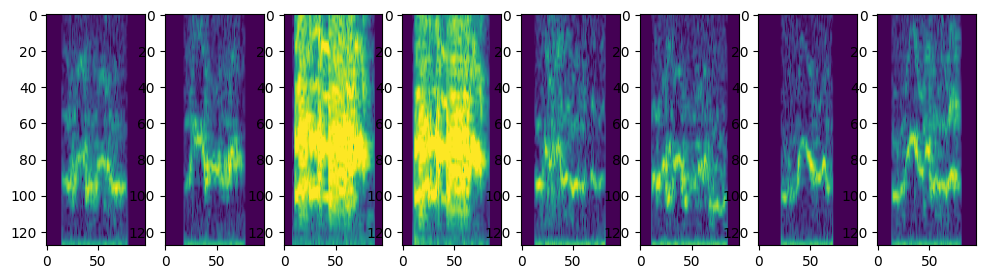

In [34]:
# prange = range(0, 5)
prange = random.sample(range(len(spec_dirs_all[0])), 8)
fig, ax = plt.subplots(1, len(prange), figsize=[12,3])
with h5py.File(fn_h5_all[0], 'r') as file:
    dataset = file['spec_data']
    print(dataset.shape)
    for ii in range(len(ax)):
        spec = dataset[prange[ii],:,:]
        ax[ii].imshow(np.flip(spec, 0), aspect='auto')

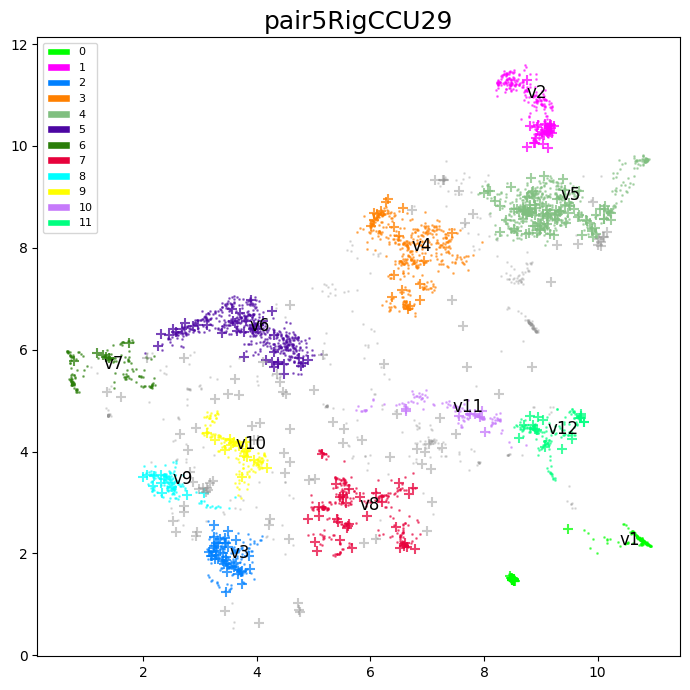

In [35]:
# overlay new data on trained data to check quality of generalization: focal bird
fn_old = os.path.join(fd_model_base, f'clusterSep_full_{focal_bird}.csv')
res_old = pd.read_csv(fn_old, index_col=0)
res_new = res_pd_all[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7, 7], sharex=True, sharey=True)
# color_list = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#1f78b4']
# color_list = seaborn.color_palette('husl', num_cluster)
num_cluster = np.max(res_old['cluster'])+1
color_list = distinctipy.get_colors(num_cluster, rng=1992)
# plot different syllable types
for ci in range(num_cluster):
    idx = res_old[res_old['cluster']==ci].index
    ax.scatter(res_old['umap1'][idx], res_old['umap2'][idx], s=1, color=color_list[ci], alpha=0.5, marker='o')
    # add a cluster text label
    ax.text(np.mean(res_old['umap1'][idx]), np.mean(res_old['umap2'][idx]), f'{focal_syl}{ci+1}', fontsize=12)
    idx = res_new[res_new['cluster']==ci].index
    ax.scatter(res_new['umap1'][idx], res_new['umap2'][idx], s=50, color=color_list[ci], alpha=0.75, marker='+')
# plot non-cluster points as grey
idx = res_old[res_old['cluster']==-1].index
ax.scatter(res_old['umap1'][idx], res_old['umap2'][idx], s=1, color='#969696', alpha=0.25, marker='o')
idx = res_new[res_new['cluster']==-1].index
ax.scatter(res_new['umap1'][idx], res_new['umap2'][idx], s=50, color='#969696', alpha=0.5, marker='+')
ax.set_title(focal_bird, fontsize=18)
# add legend 
custom_legend = [Patch(facecolor=col, edgecolor='white') for col in color_list]
ax.legend(custom_legend, [str(aa) for aa in range(num_cluster)], loc="upper left", fontsize=8)
plt.tight_layout()

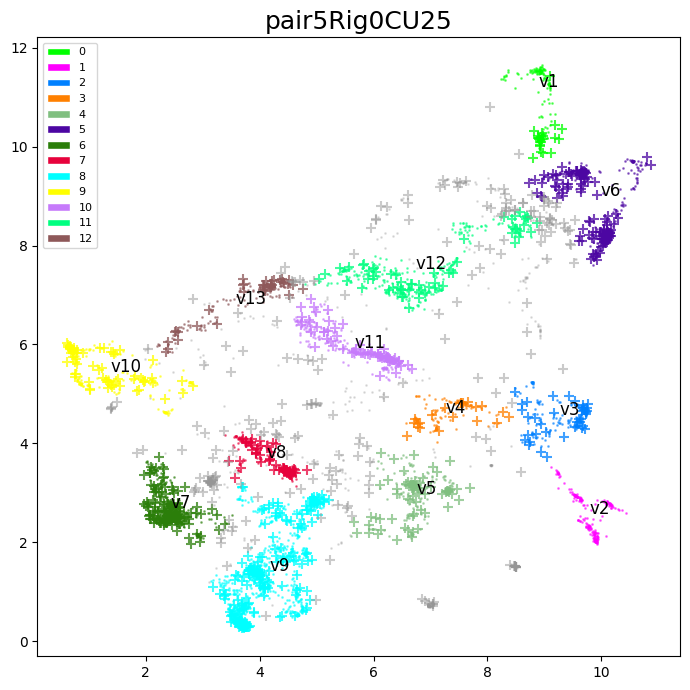

In [36]:
# overlay new data on trained data to check quality of generalization: partner bird
partner_bird = birdIDs[1-focal_bird_idx]
fn_old = os.path.join(fd_model_base, f'clusterSep_full_{partner_bird}.csv')
res_old = pd.read_csv(fn_old, index_col=0)
res_new = res_pd_all[1]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7, 7], sharex=True, sharey=True)
# color_list = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#1f78b4']
# color_list = seaborn.color_palette('husl', num_cluster)
num_cluster = np.max(res_old['cluster'])+1
color_list = distinctipy.get_colors(num_cluster, rng=1992)
# plot different syllable types
for ci in range(num_cluster):
    idx = res_old[res_old['cluster']==ci].index
    ax.scatter(res_old['umap1'][idx], res_old['umap2'][idx], s=1, color=color_list[ci], alpha=0.5, marker='o')
    ax.text(np.mean(res_old['umap1'][idx]), np.mean(res_old['umap2'][idx]), f'{focal_syl}{ci+1}', fontsize=12)
    idx = res_new[res_new['cluster']==ci].index
    ax.scatter(res_new['umap1'][idx], res_new['umap2'][idx], s=50, color=color_list[ci], alpha=0.75, marker='+')
# plot non-cluster points as grey
idx = res_old[res_old['cluster']==-1].index
ax.scatter(res_old['umap1'][idx], res_old['umap2'][idx], s=1, color='#969696', alpha=0.25, marker='o')
idx = res_new[res_new['cluster']==-1].index
ax.scatter(res_new['umap1'][idx], res_new['umap2'][idx], s=50, color='#969696', alpha=0.5, marker='+')
ax.set_title(partner_bird, fontsize=18)
# add legend 
custom_legend = [Patch(facecolor=col, edgecolor='white') for col in color_list]
ax.legend(custom_legend, [str(aa) for aa in range(num_cluster)], loc="upper left", fontsize=8)
plt.tight_layout()